In [345]:
import os
import pandas as pd
import numpy as np

current_folder_path = os.getcwd()
directory = "./stock-importer/stocknet-dataset/price/raw"
filename = "AAPL.csv"

filename = os.path.join(current_folder_path, directory,filename)

df_reversed = pd.read_csv(filename)
df = df_reversed.sort_values(by='Date', ascending=False)
df = df.iloc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

SEED = 2

In [346]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
...,...,...,...,...,...,...
2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000
2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900
2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600


In [347]:
from statsmodels.tsa.arima.model import ARIMA


def smape(actual, forecast):
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast) / denominator
    diff[denominator == 0] = 0.0  # to avoid division by zero error
    return 100 * np.mean(diff)

def mase(actual, forecast, seasonal_period=1):
    n = len(actual)
    d = np.abs(np.diff(actual, n=seasonal_period)).sum() / (n - seasonal_period)
    errors = np.abs(actual - forecast)
    return errors.mean() / d

column_value = 'Adj Close'


In [348]:
# # Box Cox transformation
# from scipy.stats import boxcox
# 
# df[f"{column_value}"] = boxcox(df[f"{column_value}"].values)[0]

In [349]:
# boxcox(df[f"{column_value}"].values)

In [350]:
num_trials = 5

In [351]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
from hyperopt.pyll.base import scope
from sklearn.metrics import mean_absolute_error
import warnings
# warnings.filterwarnings('ignore')

def smape(actual, forecast):
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast) / denominator
    diff[denominator == 0] = 0.0  # to avoid division by zero error
    return 100 * np.mean(diff)

def mase(actual, forecast, seasonal_period=1):
    n = len(actual)
    d = np.abs(np.diff(actual, n=seasonal_period)).sum() / (n - seasonal_period)
    errors = np.abs(actual - forecast)
    return errors.mean() / d




# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

orders = (11,11,11)

def objective(params):
    p = int(params['p'])
    d = int(params['d'])
    q = int(params['q'])
    try:
        model = ARIMA(train[f"{column_value}"], order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mase_score = mase(test[column_value].to_numpy(), forecast)
        smape_score = smape(test[column_value].to_numpy(), forecast)
        mae_score = mean_absolute_error(test[column_value], forecast)
        return {'loss': smape_score, 'status': STATUS_OK}
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")
        return {'loss': float("inf"), 'status': STATUS_FAIL}

# Define the search space
space = {
    'p': scope.int(hp.quniform('p', 1, orders[0], 1)),
    'd': scope.int(hp.quniform('d', 1, orders[1], 1)),
    'q': scope.int(hp.quniform('q', 1, orders[2], 1))
}

# Run Hyperopt with Hyperband
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)

print(f"Best parameters: {best}")

100%|██████████| 5/5 [00:13<00:00,  2.74s/trial, best loss: 13.275115264170163]
Best parameters: {'d': 4.0, 'p': 3.0, 'q': 7.0}


In [352]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
from hyperopt.pyll.base import scope
from sklearn.metrics import mean_absolute_error
import warnings
# warnings.filterwarnings('ignore')

def smape(actual, forecast):
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast) / denominator
    diff[denominator == 0] = 0.0  # to avoid division by zero error
    return 100 * np.mean(diff)

def mase(actual, forecast, seasonal_period=1):
    n = len(actual)
    d = np.abs(np.diff(actual, n=seasonal_period)).sum() / (n - seasonal_period)
    errors = np.abs(actual - forecast)
    return errors.mean() / d




# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

orders = (11,11,11)

def objective_combined(params):
    p = int(params['p'])
    d = int(params['d'])
    q = int(params['q'])
    try:
        model = ARIMA(train[f"{column_value}"], order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mase_score = mase(test[column_value].to_numpy(), forecast)
        smape_score = smape(test[column_value].to_numpy(), forecast)
        return {'loss': smape_score + mase_score, 'status': STATUS_OK}
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")
        return {'loss': float("inf"), 'status': STATUS_FAIL}

# Define the search space
space = {
    'p': scope.int(hp.quniform('p', 1, orders[0], 1)),
    'd': scope.int(hp.quniform('d', 1, orders[1], 1)),
    'q': scope.int(hp.quniform('q', 1, orders[2], 1))
}

# Run Hyperopt with Hyperband
trials = Trials()
best_combined = fmin(
    fn=objective_combined,
    space=space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)

print(f"Best parameters: {best_combined}")

100%|██████████| 5/5 [00:12<00:00,  2.60s/trial, best loss: 34.736683388302964]
Best parameters: {'d': 4.0, 'p': 3.0, 'q': 7.0}


{'d': 4.0, 'p': 3.0, 'q': 7.0}
{'d': 4.0, 'p': 3.0, 'q': 7.0}


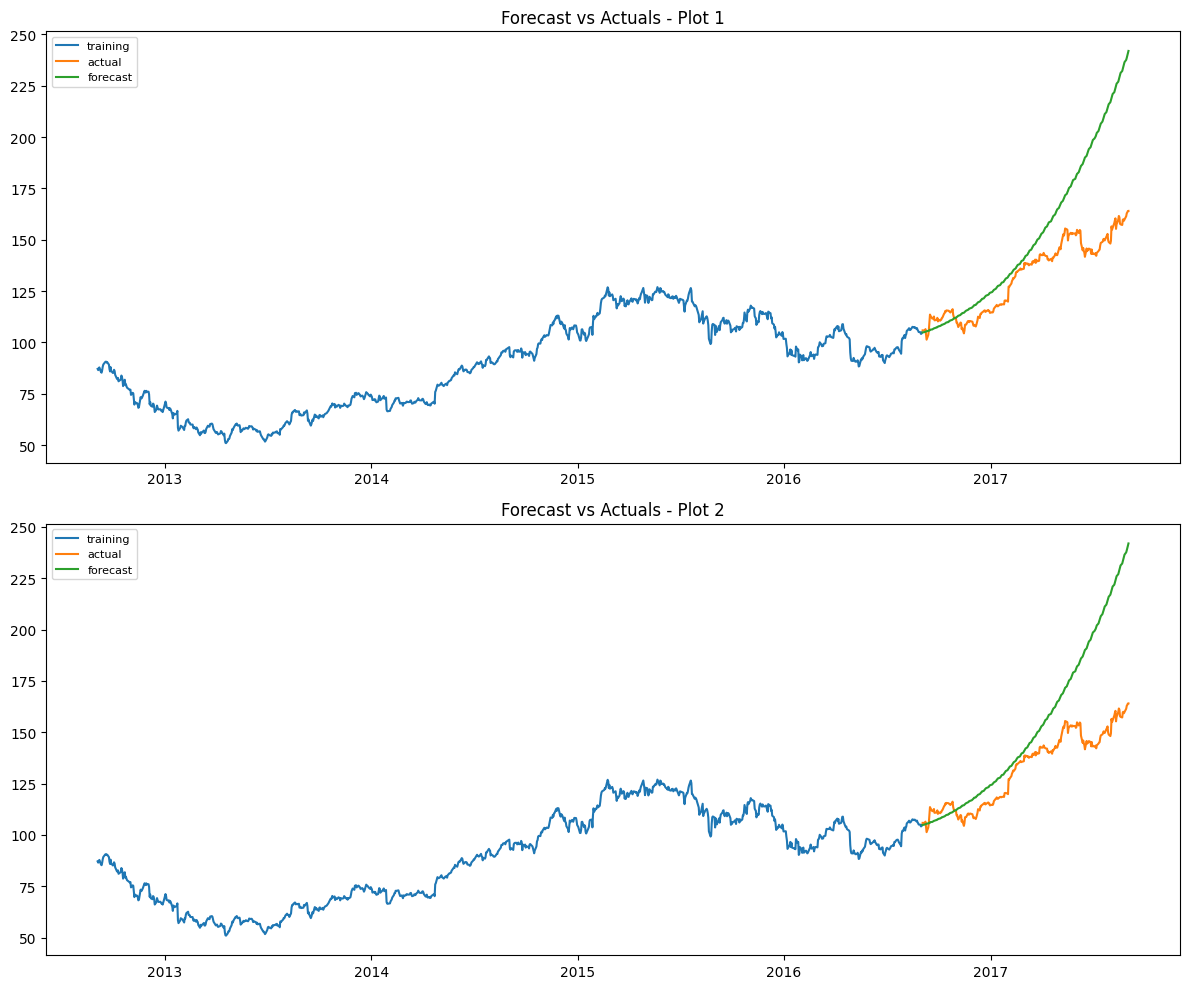

In [353]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=100)  # Create 2x2 subplot grid

params = (best, best_combined)

for i, ax in enumerate(axs.flatten()):
    print(params[i])
    model = ARIMA(train[f"{column_value}"], order=(params[i]['p'], params[i]['d'], params[i]['q']))
    fitted = model.fit()

    # Forecast
    fc = fitted.forecast(steps=len(test))  # 95% conf
    fc.index = test.index

    # Plot on specific subplot
    ax.plot(train[f"{column_value}"], label='training')
    ax.plot(test[f"{column_value}"], label='actual')
    ax.plot(fc, label='forecast')
    
    ax.set_title(f'Forecast vs Actuals - Plot {i+1}')
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


In [354]:
from statsmodels.tsa.stattools import acf
from pprint import pprint

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'smape': smape(actual, forecast)})

pprint(forecast_accuracy(fc.values, test[f"{column_value}"].values))

{'acf1': 0.9854378049205377,
 'corr': 0.9184712508968849,
 'mae': 21.946864712434422,
 'mape': 0.15140762576785305,
 'me': 20.806531716874982,
 'minmax': 0.11889508053073117,
 'mpe': 0.14131993092383802,
 'rmse': 32.00265487648454,
 'smape': 13.275115264170163}


In [357]:
num_trials = 5

In [359]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

orders = (5,5,5,5,5,5,12)

def objective(params):
    p = int(params['p'])
    d = int(params['d'])
    q = int(params['q'])
    P = int(params['P'])
    D = int(params['D'])
    Q = int(params['Q'])
    S = int(params['S'])
    try:
        model = SARIMAX(train[f"{column_value}"], order=(p, d, q), seasonal_order=(P, D, Q, S)) 
        # model = ARIMA(train[f"{column_value}"], order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mase_score = mase(test[column_value].to_numpy(), forecast)
        smape_score = smape(test[column_value].to_numpy(), forecast)
        return {'loss': smape_score, 'status': STATUS_OK}
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")
        return {'loss': float("inf"), 'status': STATUS_FAIL}

def objective_combined(params):
    p = int(params['p'])
    d = int(params['d'])
    q = int(params['q'])
    P = int(params['P'])
    D = int(params['D'])
    Q = int(params['Q'])
    # S = int(params['S'])
    S = 12
    try:
        model = SARIMAX(train[f"{column_value}"], order=(p, d, q), seasonal_order=(P, D, Q, S)) 
        # model = ARIMA(train[f"{column_value}"], order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        mase_score = mase(test[column_value].to_numpy(), forecast)
        smape_score = smape(test[column_value].to_numpy(), forecast)
        return {'loss': smape_score + mase_score, 'status': STATUS_OK}
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")
        return {'loss': float("inf"), 'status': STATUS_FAIL}

# Define the search space
space = {
    'p': scope.int(hp.quniform('p', 1, orders[0], 1)),
    'd': scope.int(hp.quniform('d', 1, orders[1], 1)),
    'q': scope.int(hp.quniform('q', 1, orders[2], 1)),
    'P': scope.int(hp.quniform('P', 1, orders[3], 1)),
    'D': scope.int(hp.quniform('D', 1, orders[4], 1)),
    'Q': scope.int(hp.quniform('Q', 1, orders[5], 1)),
    'S': scope.int(hp.quniform('S', 11, orders[6], 1))
}

trials = Trials()
best = fmin(
    fn=objective_combined,
    space=space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)

# Run Hyperopt with Hyperband
trials = Trials()
best_combined = fmin(
    fn=objective_combined,
    space=space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)



  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44203D+00    |proj g|=  1.97381D-01
  0%|          | 0/5 [00:05<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=100)  # Create 2x2 subplot grid

params = (best, best_combined)

for i, ax in enumerate(axs.flatten()):
    print(params[i])
    model = ARIMA(train[f"{column_value}"], order=(params[i]['p'], params[i]['d'], params[i]['q']))
    fitted = model.fit()

    # Forecast
    fc = fitted.forecast(steps=len(test))  # 95% conf
    fc.index = test.index

    # Plot on specific subplot
    ax.plot(train[f"{column_value}"], label='training')
    ax.plot(test[f"{column_value}"], label='actual')
    ax.plot(fc, label='forecast')
    
    ax.set_title(f'Forecast vs Actuals - Plot {i+1}')
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
import pmdarima as pm
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)